In [225]:
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
import collections


# Загрузка данных

In [182]:
data = pd.read_csv(r'C:\EMOJI\articles_lemmatized_no_SW.csv')
data

,Unnamed: 0,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый накануне февраль возникать сложный вопр...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто
...,...,...,...,...
56495,40141,Реформа госконтроля даст двухпроцентный рост ВВП,бизнес хотеть раз снижать количество регулятор...,Экономика
56496,51705,Минэк видит основания для улучшения суверенног...,ранее первый вице-премьер рф игорь шувалов отм...,Экономика
56497,15789,Стоимость нефти растет на фоне ослабления доллара,цена влиять ожидание итог референдум членство ...,Экономика
56498,5919,ЦБ: «Данные о потерях НПФ в размере 200 млрд р...,банк россия опровергать цифра вице-премьер оль...,Экономика


# Первичный анализ данных

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56500 entries, 0 to 56499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56500 non-null  int64 
 1   headline    56500 non-null  object
 2   body        56499 non-null  object
 3   topic       56500 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [184]:
data = data.dropna()# удаляем NaN

In [185]:
data.topic.value_counts()#смотрим какие есть категории и сколько их

topic
Мир                                    15131
Общество                               12147
Политика                                7359
Страна                                  5280
Экономика                               5032
Спорт                                   4881
Культура                                2635
Армия                                   1295
Наука                                    824
Гаджеты & Телеком                        583
РИО-2016                                 449
Авто                                     130
Москва                                   118
День в истории                           108
Выборы в США                              96
Выборы-2016                               92
ПМЭФ                                      63
День Победы                               62
ЧЕ 2016                                   56
Известия: подробности                     38
Россия - регионы                          26
Новости компаний                          17
Фина

(array([5.4558e+04, 1.8450e+03, 7.0000e+01, 1.7000e+01, 4.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([9.00000e+00, 4.81760e+03, 9.62620e+03, 1.44348e+04, 1.92434e+04,
        2.40520e+04, 2.88606e+04, 3.36692e+04, 3.84778e+04, 4.32864e+04,
        4.80950e+04]),
 <BarContainer object of 10 artists>)

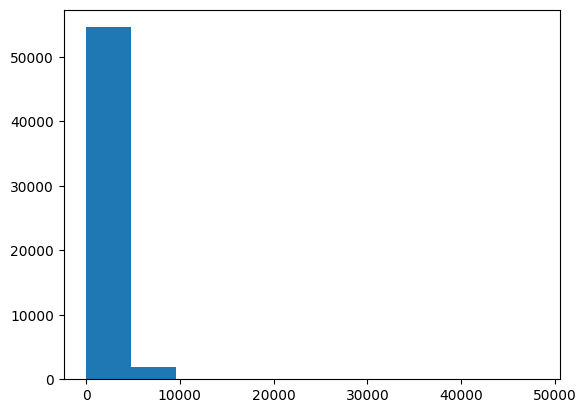

In [186]:
x = data.body 
xlen = [len(el) for el in x]# смотрим каких длин бывают новости
plt.hist(xlen)


In [187]:
data = data[data['body'].apply(len)<=8000]# оставим только новости длиной не больше 8000 знаков


In [188]:
data

,Unnamed: 0,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый накануне февраль возникать сложный вопр...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто
...,...,...,...,...
56495,40141,Реформа госконтроля даст двухпроцентный рост ВВП,бизнес хотеть раз снижать количество регулятор...,Экономика
56496,51705,Минэк видит основания для улучшения суверенног...,ранее первый вице-премьер рф игорь шувалов отм...,Экономика
56497,15789,Стоимость нефти растет на фоне ослабления доллара,цена влиять ожидание итог референдум членство ...,Экономика
56498,5919,ЦБ: «Данные о потерях НПФ в размере 200 млрд р...,банк россия опровергать цифра вице-премьер оль...,Экономика


In [189]:
y = pd.get_dummies(data.topic)# кодируем с помощью One-Hot таргет

In [190]:
y.shape

(56298, 37)

In [191]:
x = data.body # для обучения будем использовать только текст новостей

# Подход 1
## TfIdf + CatBoost

In [217]:
tok = TfidfVectorizer(max_features=20000)# токенизируем и векторизируем предложения
tok.fit(x)
X = tok.transform(x)

In [218]:
X.shape

(56298, 20000)

In [219]:
x_train, x_test, y_train, y_test = train_test_split(X,data.topic, test_size=0.2)

In [222]:
%%time
catboost = CatBoostClassifier(depth=3, min_data_in_leaf=1, learning_rate=0.05, iterations=500, verbose=1)# создаем экземпляр класса бустинга
catboost.fit(x_train, y_train)


0:	learn: 3.1440488	total: 3.67s	remaining: 30m 31s
1:	learn: 2.9344322	total: 7.23s	remaining: 30m
2:	learn: 2.7881452	total: 10.8s	remaining: 29m 42s
3:	learn: 2.6647413	total: 14.1s	remaining: 29m 11s
4:	learn: 2.5681440	total: 17.5s	remaining: 28m 51s
5:	learn: 2.4698332	total: 20.9s	remaining: 28m 38s
6:	learn: 2.3925513	total: 24.3s	remaining: 28m 31s
7:	learn: 2.3272426	total: 27.8s	remaining: 28m 32s
8:	learn: 2.2722098	total: 31.3s	remaining: 28m 30s
9:	learn: 2.2194777	total: 34.8s	remaining: 28m 26s
10:	learn: 2.1694319	total: 38.3s	remaining: 28m 22s
11:	learn: 2.1234270	total: 41.8s	remaining: 28m 18s
12:	learn: 2.0787782	total: 45.2s	remaining: 28m 14s
13:	learn: 2.0415030	total: 48.6s	remaining: 28m 8s
14:	learn: 2.0036951	total: 52s	remaining: 28m 2s
15:	learn: 1.9724143	total: 55.5s	remaining: 27m 58s
16:	learn: 1.9402021	total: 58.9s	remaining: 27m 52s
17:	learn: 1.9093623	total: 1m 2s	remaining: 27m 49s
18:	learn: 1.8803425	total: 1m 5s	remaining: 27m 45s
19:	learn: 

In [223]:
y_pred = catboost.predict(x_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.7207815275310835


# Подход 2
## Tfidf + полносвязная нейросеть

In [210]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [211]:
dataset = TensorDataset(torch.from_numpy(x_train.toarray()), torch.from_numpy(y_train.to_numpy()))
# Создание загрузчика данных
dataloader = DataLoader(dataset, batch_size=16)

In [212]:
# Создание модели
model_nn = nn.Sequential(nn.Linear(20000, 200), nn.ReLU(), nn.Linear(200, 200), nn.ReLU(), nn.Linear(200, 37), nn.Softmax())
model_nn

Sequential(
  (0): Linear(in_features=20000, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=37, bias=True)
  (5): Softmax(dim=None)
)

In [213]:
loss_func = nn.CrossEntropyLoss()# инициализируем функцию потерь и оптимизатор
optim = torch.optim.Adam(model_nn.parameters(), lr=0.001)

In [214]:
%%time 
# обычный train-loop
acc= []
for epoch in range(10):
    for x_tr, y_tr in tqdm(dataloader):# для каждой эпохи проходимся по всему датасету 
        y_pred = model_nn(x_tr.float())# считаем предсказания модели
        loss = loss_func(y_pred, y_tr.float())# считаем ошибку
        loss.backward()
        optim.step()# шаг оптимизатора
        optim.zero_grad()# обновляем градиенты
    y_pred_t = model_nn(torch.from_numpy(x_test.toarray()).float())
    y_pred_i= (y_pred_t >= 0.5).int()
    acc.append(accuracy_score(y_test, y_pred_i))#считаем accuracy на тесте для каждой эпохи
    print(epoch, "epoch finished, accuracy on test =", accuracy_score(y_test, y_pred_i))




  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 epoch finished, accuracy on test = 0.7018650088809947


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


1 epoch finished, accuracy on test = 0.7011545293072824


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


2 epoch finished, accuracy on test = 0.7018650088809947


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


3 epoch finished, accuracy on test = 0.713854351687389


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


4 epoch finished, accuracy on test = 0.7199822380106572


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5 epoch finished, accuracy on test = 0.7511545293072824


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


6 epoch finished, accuracy on test = 0.7548845470692718


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


7 epoch finished, accuracy on test = 0.7576376554174068


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


8 epoch finished, accuracy on test = 0.7579928952042628


  0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


9 epoch finished, accuracy on test = 0.7559502664298401
CPU times: total: 1h 19s
Wall time: 10min 5s


# Подход 3
## Embedding с рекурентными и сверточными нейронными сетями


In [192]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = [self.vocab.get(word, self.vocab['<UNK>']) for word in text.split()]
        tokens = tokens[:self.max_length] # Truncation
        tokens = torch.tensor(tokens)
        padded_tokens = torch.zeros(self.max_length, dtype=torch.long) # Padding
        padded_tokens[:len(tokens)] = tokens
        label = self.labels[idx]
        return padded_tokens, torch.tensor(label)

In [193]:
def create_vocab(texts, max_size=10000):
    vocab = collections.Counter()# используем Counter чтобы иметь функционал словаря и most_common
    for text in texts:
        for word in text.split():
            vocab[word] += 1# считаем сколько раз встречается каждое слово
    vocab = vocab.most_common(max_size)# берем только max_size самых популярных
    vocab = {word: index+1 for index, (word, count) in enumerate(vocab)}# нумеруем начиная с 1, так как 0 для паддинга
    vocab["<UNK>"] = len(vocab)+1
    vocab["<PAD>"] = 0
    return vocab

In [194]:
def create_vocab(texts, max_size=10000):
    vocab = collections.Counter()
    for text in texts:
        for word in text.split():
            vocab[word] += 1
    vocab = vocab.most_common(max_size)
    vocab = {word: index for index, (word, count) in enumerate(vocab)}
    vocab["<UNK>"] = len(vocab)
    vocab["<PAD>"] = len(vocab) + 1
    return vocab

In [195]:
class NewsClassifier(nn.Module):# определяем нашу модель
    def __init__(self, vocab_size, embedding_dim, dense_size):
        super(NewsClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.conv1d = nn.Conv1d(embedding_dim, 32, kernel_size=3)
        self.maxpool = nn.MaxPool1d(kernel_size=3)
        self.lstm = nn.LSTM(32, 100)
        self.dropout2 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(100, dense_size)
        self.dense2 = nn.Linear(dense_size, 37)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1) #(batch_size, seq_len, embedding_dim) -> (batch_size, embedding_dim, seq_len) для сверточной части
        x = self.dropout1(x)
        x = self.conv1d(x)
        x = self.maxpool(x)
        x, _ = self.lstm(x.permute(2, 0, 1)) # (seq_len, batch_size, hidden_size) для рекурентной части
        x = self.dropout2(x[-1])
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [196]:
vocab = create_vocab(x, 20000)# создаем словарь из 20000 самых популярных слов в новостях
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [197]:
X = x.to_list()
Y = y.to_numpy().astype('float')

vocab = create_vocab(x, 20000)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)


In [198]:
train_dataset = NewsDataset(x_train, y_train, vocab, 500)
test_dataset = NewsDataset(x_test, y_test, vocab, 500)
# создаем датасеты и даталоадеры
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [199]:
model = NewsClassifier(len(vocab), 128, 500)# инициализируем модель функцию потерь и опимизатор
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [200]:
%%time 
# обычный train-loop
for epoch in range(5):
    for x_tr, y_tr in tqdm(train_loader):# для каждой эпохи проходимся по всему датасету 
        optim.zero_grad()# обновляем градиенты

        y_pred = model(x_tr.int())# считаем предсказания модели
        loss = loss_func(y_pred, y_tr.float())# считаем ошибку
        loss.backward()
        optim.step()# шаг оптимизатора
    print(epoch, " epoch finished, loss =",loss.item())

  0%|          | 0/1584 [00:00<?, ?it/s]

0  epoch finished, loss = 1.6227446794509888


  0%|          | 0/1584 [00:00<?, ?it/s]

1  epoch finished, loss = 0.9579129219055176


  0%|          | 0/1584 [00:00<?, ?it/s]

2  epoch finished, loss = 0.5827446579933167


  0%|          | 0/1584 [00:00<?, ?it/s]

3  epoch finished, loss = 0.4697999656200409


  0%|          | 0/1584 [00:00<?, ?it/s]

4  epoch finished, loss = 0.33261385560035706
CPU times: total: 49min 24s
Wall time: 8min 16s


In [204]:
# Оценка модели
model.eval()
test_preds = []# создаем списки, куда будем по батчам записывать предсказания и правильные классы
test_labels_list = []

with torch.no_grad():
    for x_test, y_test in tqdm(test_loader):
        outputs = F.one_hot(torch.argmax(model(x_test), 1), 37)# предсказываем и форматируем данные

        test_preds.extend(outputs.cpu().numpy())
        test_labels_list.extend(y_test.cpu().numpy())
    accuracy = accuracy_score(test_labels_list, test_preds)# считаем accuracy сразу на всем тестовом датасете
    print(f"Test Accuracy: {accuracy:.4f}")

  0%|          | 0/176 [00:00<?, ?it/s]

Test Accuracy: 0.7655


# Подход 4
## Fine-tunning предобученной LLM

In [30]:
class NewsDataset(Dataset):# определяем класс датасета
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer # сюда передаем токенизатор от ллм которую будем использовать
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length', # кодируем и обрезаем до одного разера каждый элемент
            return_tensors='pt'
        )

        return [encoded_text['input_ids'].squeeze(),# возвращаем индексы, таргеты и маску
            encoded_text['attention_mask'].squeeze(),
            torch.tensor(label)]

In [31]:
# определяем класс модели, будем использовать предобученный RuBERT
class NewsClassifier(nn.Module):
    def __init__(self, num_classes, pretrained_model_name='DeepPavlov/rubert-base-cased'):
        super(NewsClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return logits

In [32]:
# токенизатор используем обязательно тоже от RuBERT
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

texts =x.to_list()
labels = np.array(y).astype('float')
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2)
train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)
# создаем даатсеты и даталоадеры
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\Александр\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
#создаем экземпляр нашей модели
model = NewsClassifier(num_classes=37)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
optim = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

In [35]:
%%time 
# обычный train-loop
for epoch in range(3):
    for x_tr, mask, y_tr in tqdm(train_loader):# для каждой эпохи проходимся по всему датасету 
        y_pred = model(x_tr, mask)# считаем предсказания модели
        loss = loss_func(y_pred, y_tr.float())# считаем ошибку
        loss.backward()
        optim.step()# шаг оптимизатора
        optim.zero_grad()# обновляем градиенты

  0%|          | 0/2815 [00:00<?, ?it/s]

  0%|          | 0/2815 [00:00<?, ?it/s]

  0%|          | 0/2815 [00:00<?, ?it/s]

CPU times: total: 2d 16h 51min 6s
Wall time: 10h 49min 1s


In [36]:
# Оценка модели
model.eval()
test_preds = []# создаем списки, куда будем по батчам записывать предсказания и правильные классы
test_labels_list = []

with torch.no_grad():
    for x_test,mask, y_test in tqdm(test_loader):
        outputs = F.one_hot(torch.argmax(model(x_test, mask), 1), 37)# предсказываем и форматируем данные

        test_preds.extend(outputs.cpu().numpy())
        test_labels_list.extend(y_test.cpu().numpy())
    accuracy = accuracy_score(test_labels_list, test_preds)# считаем accuracy сразу на всем тестовом датасете
    print(f"Test Accuracy: {accuracy:.4f}")

  0%|          | 0/704 [00:00<?, ?it/s]

Test Accuracy: 0.8037


# Анализ результатов

Подход №1: accuracy=0.72, время обучения = 30 минут 

Подход №2: accuracy=0.755, время обучения = 10 минут

Подход №3: accuracy=0.765, время обучения = 8 минут

Подход №4: accuracy=0.80, время обучения = 11 часов

* Бустинг, хоть и является одним из самых эффективных алгоритмов классического ML показал себя довольно слабо на фоне конкурентов, применять его с Tfidf представлениями новостей не очень эффективно

* Полносвязная сеть показала себя уже лучше, быстрее обучилась и добилась лучших результатов.

* Методы глубокого обучения, а именно рекурентные и сверточные сети показали себя еще немного лучше, они уже были способны как учитывать порядок слов в предложении, так и смысл каждого отдельного слова, но в контексте задачи классификации новостей это не так важно.

* Лучший результат показала дообученная LLM RuBERT, большие языковые модели способны понимать текст на уровне человека и отлично справляются с различными NLP задачами.

* Однако обучение, хранение и использование LLM требует очень много времени и ресурсов компьютера, что не всегда оправдано. Иногда стандратные ML/DL алгоритмы показывают результаты не сильно хуже, обучаясь гораздо быстрее. 

* Стоит также отметить, что 80% точности это очень хороший результат, так как данные максимально неоднородные. Всего лишь 8/37 классов имели более 1000 экземпляров в составе, а 15/37 классов вообще имели не более 10 примеров, на таких данных модели обучиться совсем не просто.

# Подытожим

* Классические алгоритмы ML справились с классификацией текстов хуже нейронных сетей.

* Учитывание порядка слов с помощью RNN и CNN дало незначительный прирост в качестве на уровне погрешности, для этой задачи порядок особо не важен.

* Если цель получить максимальную точность, нужно использовать LLM, но в таком случае обучение займет много времени.

* Оптимальное качество при малом времени обучения показывают нейронные сети.

* В условиях большого дисбаланса классов и не очень большого датасета модели справились с задачей очень хорошо.